In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R')
    source('../R/utils.R')
})

# Prepare data

In [2]:
exprs <- list()
exprs$celseq <- readRDS('../data/figure5/celseq_raw.rds')
exprs$celseq2 <- readRDS('../data/figure5/celseq2_raw.rds')
exprs$c1 <- readRDS('../data/figure5/c1_raw.rds')
exprs$smartseq <- readRDS('../data/figure5/ss2_raw.rds')
exprs$indrop <- readRDS('../data/figure5/indrop_raw.rds')


In [3]:
for (dname in names(exprs)) {
    colnames(exprs[[dname]]) <- paste0(dname, "_", colnames(exprs[[dname]]))    
}


In [4]:
genes_common <- exprs %>% lapply(rownames) %>% purrr::reduce(intersect)
length(genes_common)


[1] 15369

In [5]:
exprs_raw <- exprs %>% 
    lapply(function(x) x[genes_common, ]) %>%
   purrr::reduce(Matrix::cbind2)


In [6]:
meta_data <- fread('../data/figure5/metadata.csv')


Note the two levels of batch here: donor and technology. 

In [7]:
head(meta_data)
table(meta_data$dataset)
table(meta_data$donor)

cell_id,dataset,nGene,donor,cell_type,cell_subtype
<chr>,<chr>,<int>,<chr>,<chr>,<chr>
celseq_D2ex_1,celseq,1968,D2,acinar,acinar
celseq_D2ex_2,celseq,2627,D2,acinar,acinar
celseq_D2ex_3,celseq,1968,D2,acinar,acinar
celseq_D2ex_4,celseq,4097,D2,ductal,ductal
celseq_D2ex_5,celseq,2334,D2,ductal,ductal
celseq_D2ex_6,celseq,2418,D2,ductal,ductal



      c1   celseq  celseq2   indrop smartseq 
     638      946     2238     8569     2355 


          AZ          D10          D17           D2          D28          D29 
          60           95          406           76          346          551 
          D3          D30          D31           D7    HP1502401 HP1504101T2D 
         106          679          662          263          251          254 
   HP1504901    HP1506401    HP1507101 HP1508501T2D    HP1509101 HP1525301T2D 
         192          261          280          294          175          285 
HP1526901T2D       human1       human2       human3       human4           X1 
         303         1937         1724         3605         1303           34 
         X10          X11          X12          X13           X2           X3 
          56           37           57           51           49           53 
          X4           X5           X6           X7           X8           X9 
          57           45           48           55           39           57 

Technology specific filtering 

In [8]:
meta_data <- meta_data %>% subset(
    (dataset == "indrop" & nGene > 500) | 
    (dataset == "celseq" & nGene > 1750) |
    (dataset == "celseq2" & nGene > 2500) |    
    (dataset == "c1" & nGene > 0) |
    (dataset == "smartseq" & nGene > 2500)
)

Normalize data (log CP10K)

In [9]:
genes_use <- which(Matrix::rowSums(exprs_raw[, meta_data$cell_id] != 0) >= 10)
genes_use <- genes_use[which(!grepl('^MT-', names(genes_use)))]
exprs_norm <- exprs_raw[genes_use, meta_data$cell_id] %>% 
    normalizeData(method = 'log', 1e4)

Select variable genes

In [10]:
vargenes_df <- singlecellmethods::findVariableGenes(exprs_norm, meta_data$dataset)
var_genes <- unique(data.table(vargenes_df)[, head(.SD[order(-gene_dispersion_scaled)], 1000), by = group][, symbol])

PCA embedding

In [11]:
pca_res <- exprs_norm[var_genes, ] %>% 
    singlecellmethods::scaleData() %>% 
    irlba::irlba(30)
pca_embeddings <- pca_res$v %*% diag(pca_res$d)        

UMAP embedding

In [12]:
pca_umap <- do_umap(pca_embeddings)

# Harmony

Let's account for both dataset and donor in the Harmony model. Because donor effect is more mild than dataset, we give donor a smaller theta ($\theta_{donor}=1$ vs $\theta_{dataset}=2$). 

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony converged after 6 iterations



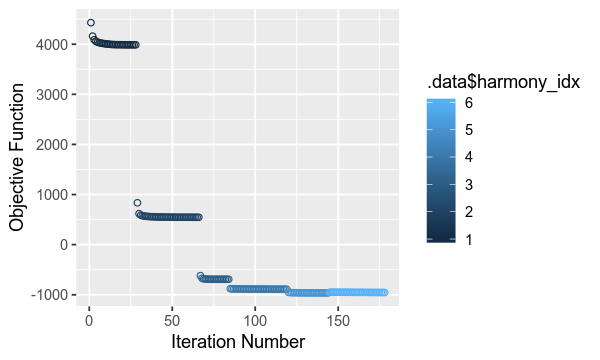

In [13]:
fig.size(3, 5)
harmony_embeddings <- HarmonyMatrix(
    pca_embeddings, 
    meta_data,
    c('dataset', 'donor'), 
    theta=c(2, 1), 
    do_pca=FALSE, 
    plot_convergence=TRUE
)

In [14]:
harmony_umap <- do_umap(harmony_embeddings)

# LISI 

In [15]:
lisi_res <- rbind(
    lisi::compute_lisi(harmony_embeddings, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'harmony'),
    lisi::compute_lisi(pca_embeddings, meta_data, c('dataset', 'donor', 'cell_type')) %>% 
        dplyr::mutate(type = 'pca')
) %>% 
    tidyr::gather(key, val, cell_type, dataset, donor)

In [16]:
head(lisi_res)


,type,key,val
,<chr>,<chr>,<dbl>
1,harmony,cell_type,1.000000
2,harmony,cell_type,1.019974
3,harmony,cell_type,1.000000
4,harmony,cell_type,1.000000
5,harmony,cell_type,1.000000
6,harmony,cell_type,1.006600


Warning message:
“Removed 23310 rows containing non-finite values (stat_density).”


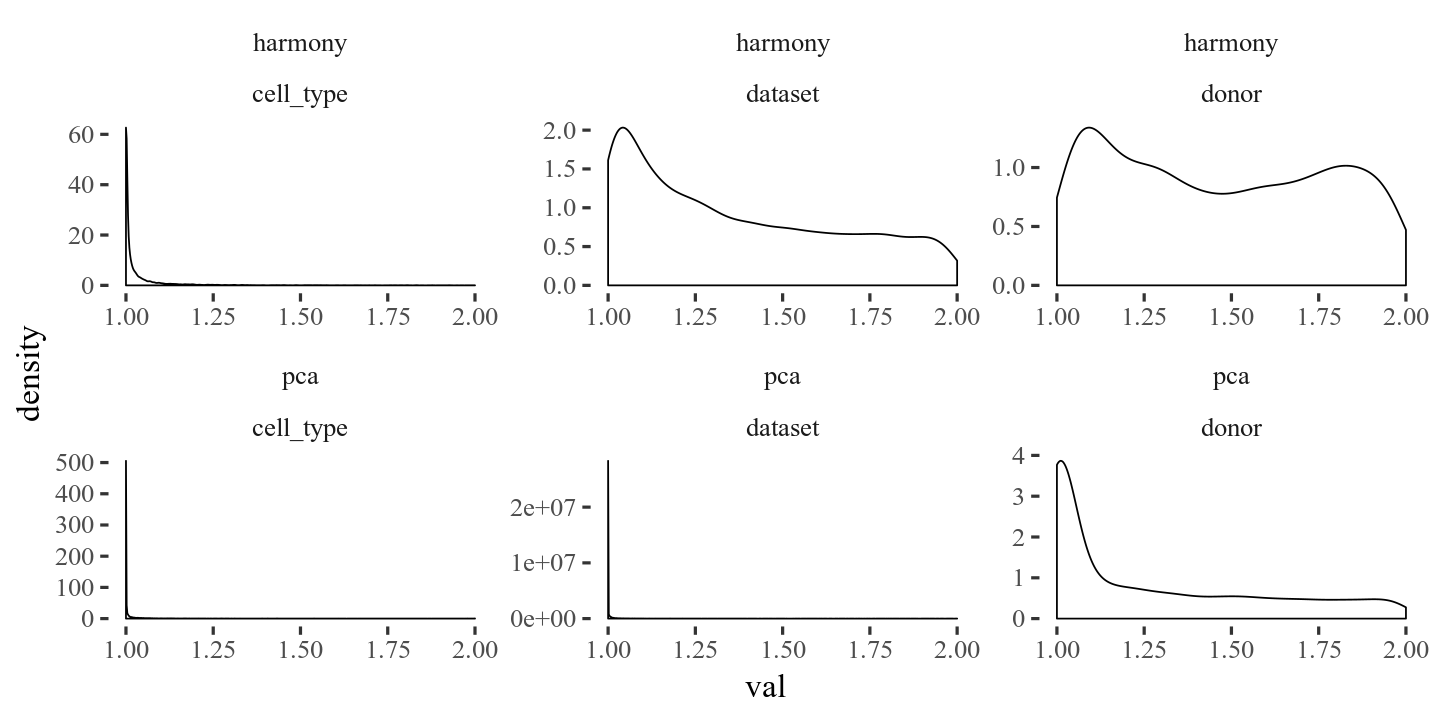

In [17]:
fig.size(6, 12)
lisi_res %>% 
    ggplot(aes(val)) + 
        geom_density() + 
        facet_wrap(~type + key, scales = 'free') + 
        theme_tufte(base_size = 20) +
        xlim(1, 2)


# Figures

In [18]:
colors_use <- readRDS('/data/srlab1/ik936/harmony2019/data/figure5/colors.rds')

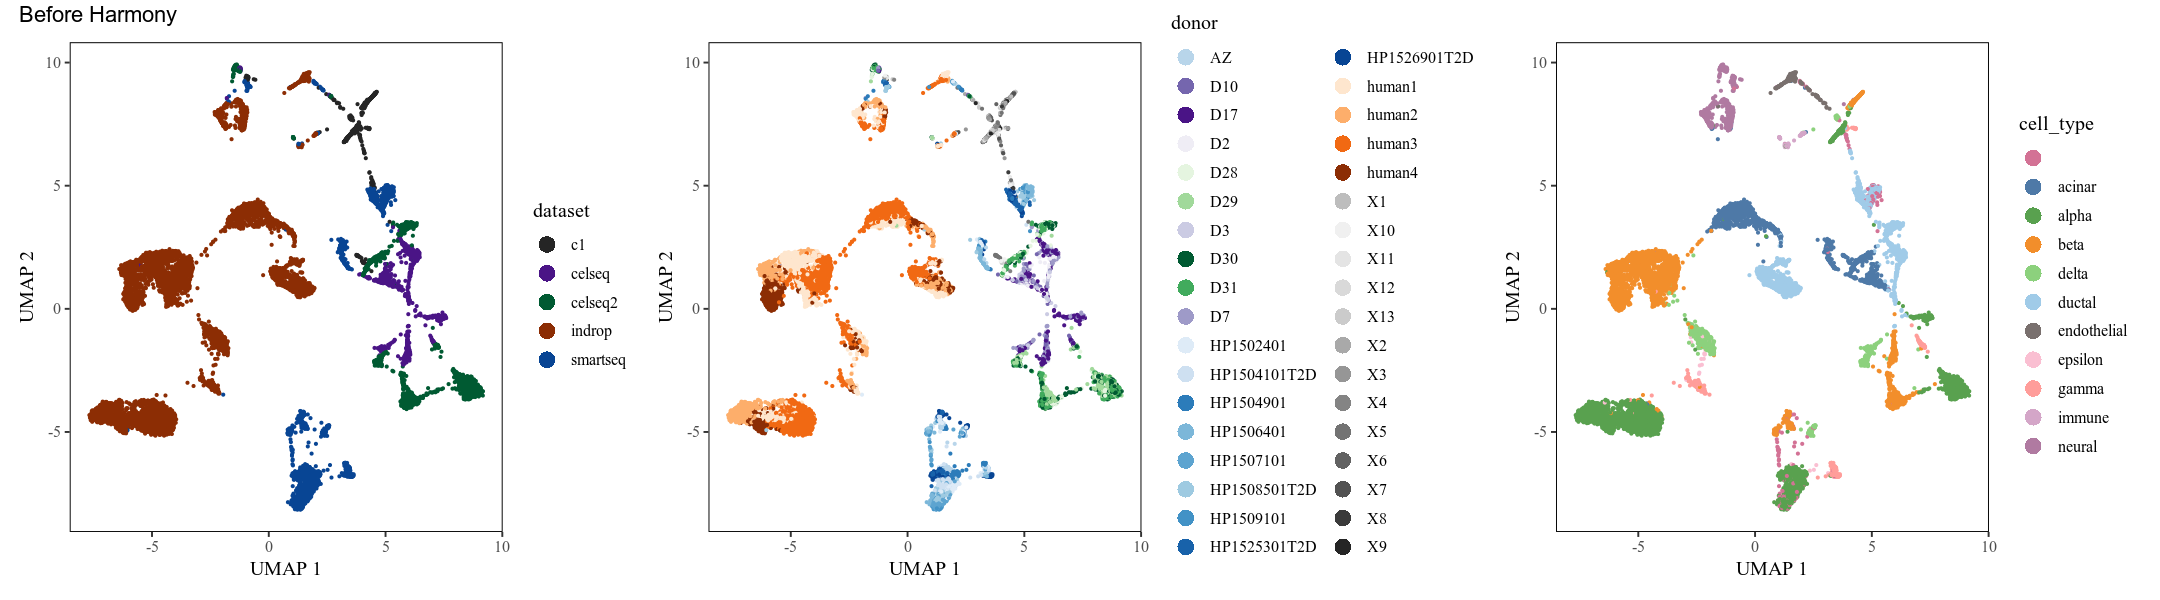

In [19]:
fig.size(5, 18)
do_scatter(pca_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(pca_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'Before Harmony')

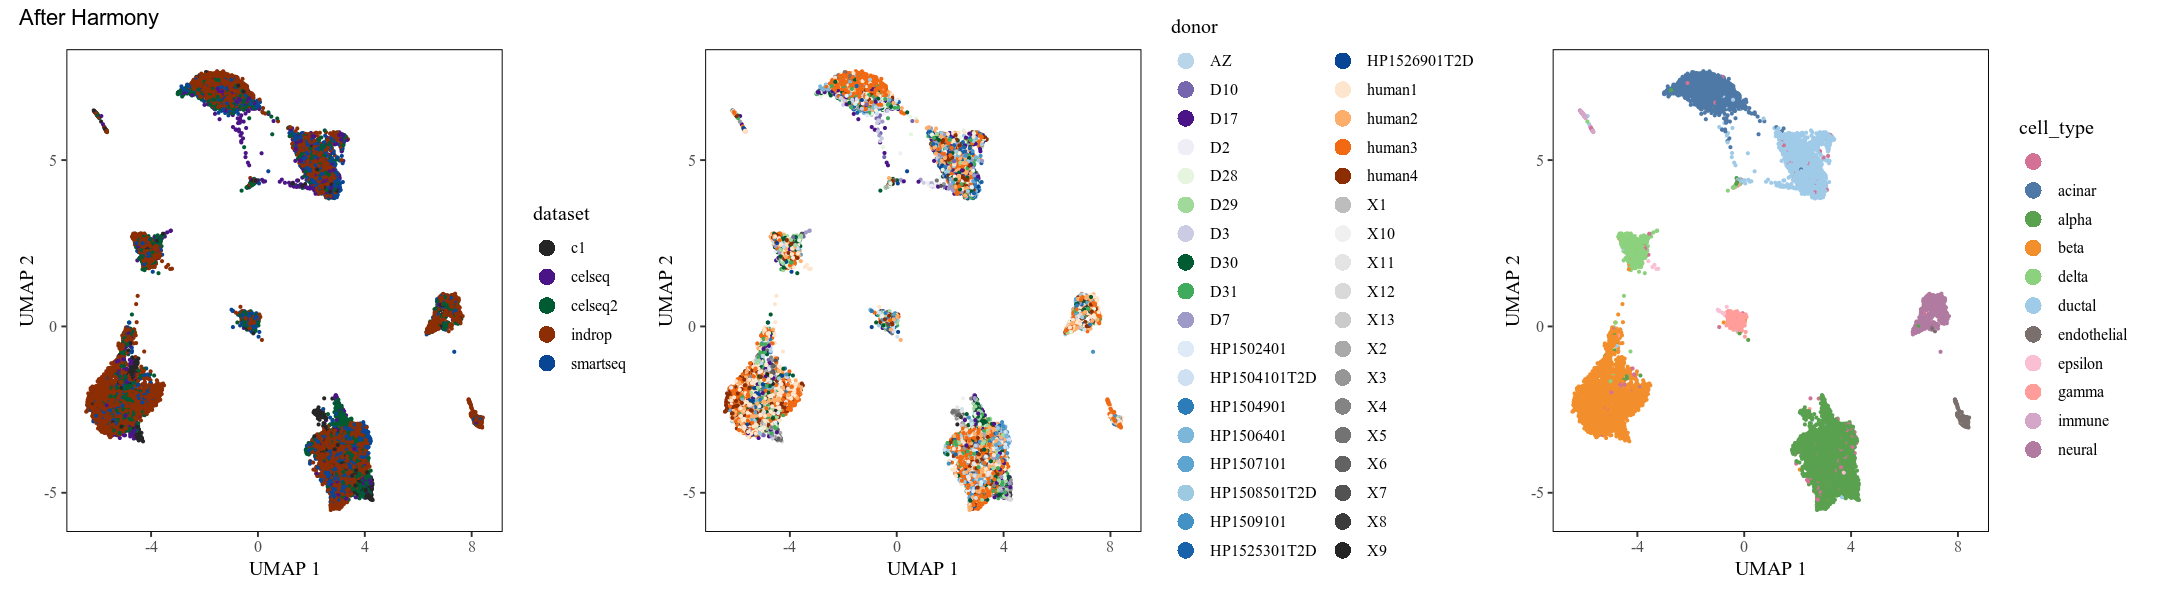

In [23]:
fig.size(5, 18)
do_scatter(harmony_umap, meta_data, 'dataset', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'donor', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
do_scatter(harmony_umap, meta_data, 'cell_type', palette_use = colors_use, pt_shape = 21, pt_size = .2) + 
plot_annotation(title = 'After Harmony')
